## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [2]:
# Path to the miner directory
BASE_PATH = os.path.join(os.path.expanduser('~'),'Projects',
                         'ISB','miner3')

DATA_PATH = os.path.join(os.path.expanduser('~'), 'Projects',
                         'ISB', 'baliga-miner2', 'MATTDATA')

# create name for results folder where output files will be saved
RESULTS_FOLDER = "results_miner3_stabilized"

# name of the folder containing the miner network
#networkFolder = "results_minCorrelation_0o2_50_allFiles"
NETWORK_PATH = os.path.join(os.path.expanduser('~'), 'Projects',
                            'ISB', 'baliga-miner2', 'MATTRESULT')

# create results directory
RESULTS_DIR = os.path.join(BASE_PATH, RESULTS_FOLDER)
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

## Load primary data

In [3]:
# Load expression Data
expressionFile = os.path.join(DATA_PATH,"expression","IA12Zscore.csv")
mapfile = os.path.join(DATA_PATH, 'identifier_mappings.txt')
expressionData, conversionTable = miner.preprocess(expressionFile,
                                                   mapfile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(DATA_PATH,'mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(DATA_PATH,'mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(DATA_PATH,'mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(NETWORK_PATH,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(NETWORK_PATH,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(NETWORK_PATH,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(NETWORK_PATH,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(NETWORK_PATH,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(NETWORK_PATH,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(NETWORK_PATH,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(NETWORK_PATH,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

completed identifier conversion.
16216 genes were converted.


## Define patient populations

In [4]:
baseline_patients = [name for name in expressionData.columns if name.split("_")[2]=='1']
relapse_patients = [name for name in expressionData.columns if name.split("_")[2]=='2']
all_relapse_patients = [name for name in expressionData.columns if name.split("_")[2]!='1']
print('Baseline:',len(baseline_patients),'First relapse:',len(relapse_patients),'\nAny relapse:',len(all_relapse_patients))

Baseline: 779 First relapse: 56 
Any relapse: 102


## Load network

In [5]:
# Load Causal Mechanistic Network
filtered_causal_results = pd.read_csv(os.path.join(NETWORK_PATH,"filteredCausalResults.csv"),index_col=0,header=0)

In [6]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(NETWORK_PATH,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [7]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(NETWORK_PATH,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

In [8]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes

## Calculate network activity

In [ ]:
network_activity_overexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=overExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)
network_activity_underexpressed = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=underExpressedMembersMatrix.copy(),
                                                 minRegulons = 2)

## Plot baseline versus relapse network activity

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(-0.05, 0.6)

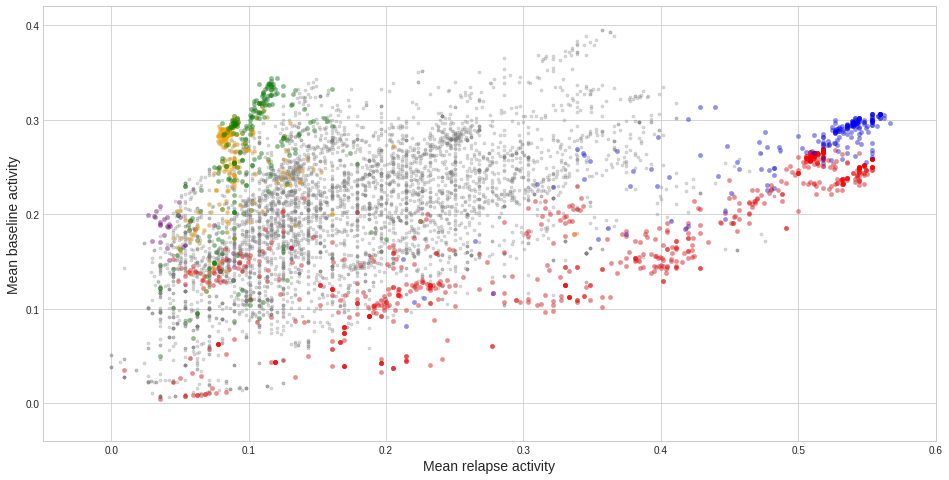

In [10]:
plt.figure(figsize=(16,8))
plt.style.use('seaborn-whitegrid')

baseline_activity = np.mean(network_activity_overexpressed.loc[:,baseline_patients],axis=1)
relapse_activity = np.mean(network_activity_overexpressed.loc[:,relapse_patients],axis=1)

baseline_activity_134 = np.mean(network_activity_overexpressed.loc[pr_genes[134],baseline_patients],axis=1)
relapse_activity_134 = np.mean(network_activity_overexpressed.loc[pr_genes[134],relapse_patients],axis=1)

baseline_activity_68 = np.mean(network_activity_overexpressed.loc[pr_genes[68],baseline_patients],axis=1)
relapse_activity_68 = np.mean(network_activity_overexpressed.loc[pr_genes[68],relapse_patients],axis=1)

baseline_activity_34 = np.mean(network_activity_overexpressed.loc[pr_genes[34],baseline_patients],axis=1)
relapse_activity_34 = np.mean(network_activity_overexpressed.loc[pr_genes[34],relapse_patients],axis=1)

baseline_activity_0 = np.mean(network_activity_overexpressed.loc[pr_genes[0],baseline_patients],axis=1)
relapse_activity_0 = np.mean(network_activity_overexpressed.loc[pr_genes[0],relapse_patients],axis=1)

baseline_activity_4 = np.mean(network_activity_overexpressed.loc[pr_genes[4],baseline_patients],axis=1)
relapse_activity_4 = np.mean(network_activity_overexpressed.loc[pr_genes[4],relapse_patients],axis=1)


plt.scatter(relapse_activity,baseline_activity,alpha=0.3,s=10,color="gray")
plt.scatter(relapse_activity_134,baseline_activity_134,alpha=0.3,s=20,color="red")
plt.scatter(relapse_activity_68,baseline_activity_68,alpha=0.3,s=20,color="blue")
plt.scatter(relapse_activity_34,baseline_activity_34,alpha=0.3,s=20,color="purple")
plt.scatter(relapse_activity_0,baseline_activity_0,alpha=0.3,s=20,color="orange")
plt.scatter(relapse_activity_4,baseline_activity_4,alpha=0.3,s=20,color="green")

plt.ylabel("Mean baseline activity",FontSize=14)
plt.xlabel("Mean relapse activity",FontSize=14)
plt.ylim(-0.04,0.42)
plt.xlim(-0.05,0.6)


## Identify selected genes from activity plot

In [11]:
# Select window of genes to identify enriched programs
condition_1 = relapse_activity.index[relapse_activity>0.5]
condition_2 = baseline_activity.index[baseline_activity<0.99]

selected_genes = list(set(condition_1)&set(condition_2))
miner.gene_conversion(selected_genes)

#Identify transcriptional programs enriched with selected genes
for p in range(len(pr_genes)):
    overlap = len(set(pr_genes[p])&set(selected_genes))
    if overlap >=20:
        print(p)

ModuleNotFoundError: No module named 'mygene'

In [95]:
#Convert genes of interest to preferred identifier
conversion = miner.gene_conversion(list(set(pr_genes[134])&set(selected_genes)))
conversion = conversion.loc[:,['_id', 'symbol']]
conversion.columns = ["Entrez","Symbol"]
conversion.head()

querying 1-197...done.
Finished.


,Entrez,Symbol
query,,
ENSG00000184730,55911,APOBR
ENSG00000004939,6521,SLC4A1
ENSG00000101336,3055,HCK
ENSG00000100504,5836,PYGL
ENSG00000119535,1441,CSF3R
